In [1]:
# C:\Users\CHUA_K\_MultiArm-Bandit
# https://tor-lattimore.com/downloads/book/book.pdf

"""
----- Psudo code -----

Choose epsilon; # exploration probability
Choose n; # number of steps / iterations

for i = 1 to n do:

  p = pick a random number from 0 to 1 
  
  if p < epsilon:
       current_bandit = pick bandit at random  # explore
  else:
       current_bandit = pick best bandit so far  # exploit
  reward = current_bandit.pull_arm()
  
  Update estimation for what rewards the current bandit gives
  
----- END -----  
"""

'\n----- Psudo code -----\n\nChoose epsilon; # exploration probability\nChoose n; # number of steps / iterations\n\nfor i = 1 to n do:\n\n  p = pick a random number from 0 to 1 \n  \n  if p < epsilon:\n       current_bandit = pick bandit at random  # explore\n  else:\n       current_bandit = pick best bandit so far  # exploit\n  reward = current_bandit.pull_arm()\n  \n  Update estimation for what rewards the current bandit gives\n  \n----- END -----  \n'

In [2]:
# Library Imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from tqdm.notebook import trange
import random
import math

class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                     gradient=False, gradient_baseline=False, true_reward=0.,
                        KLUCB=False, KL_param=None):
            self.k = k_arm
            self.step_size = step_size
            self.sample_averages = sample_averages
            self.indices = np.arange(self.k)
            self.time = 0
            self.UCB_param = UCB_param
            self.KL_param = KL_param
            self.gradient = gradient
            self.gradient_baseline = gradient_baseline
            self.average_reward = 0
            self.true_reward = true_reward
            self.epsilon = epsilon
            self.initial = initial
            self.KLUCB = KLUCB

    def reset(self):
            # real reward for each action
            self.q_true = np.random.randn(self.k) + self.true_reward

            # estimation for each action
            self.q_estimation = np.zeros(self.k) + self.initial

            # # of chosen times for each action
            self.action_count = np.zeros(self.k)

            self.best_action = np.argmax(self.q_true)

            self.time = 0
            
            self.empMean = np.zeros(self.k)
            self.rewards = np.zeros(self.k)
            self.q_prob = np.random.rand(self.k)

    def action(self):
            if np.random.rand() < self.epsilon:
                return np.random.choice(self.indices)

            if self.UCB_param is not None:
                UCB_estimation = self.q_estimation + \
                    self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
                q_best = np.max(UCB_estimation)
                return np.random.choice(np.where(UCB_estimation == q_best)[0])

            if self.gradient:
                exp_est = np.exp(self.q_estimation)
                self.action_prob = exp_est / np.sum(exp_est)
                return np.random.choice(self.indices, p=self.action_prob)
            
            if self.KLUCB:
                q_val = []
                
                #Get Emperical Mean
                
                # print(self.rewards)
                empMean = []

                for i in range(self.k):
                    if (self.action_count[i] == 0):
                        empMean.append(1e3)
                        # print('IF count: {}'.format(self.action_count[i]))
                    else:
                        empMean.append( self.rewards[i] / self.action_count[i])
                        # print('ELSE rewards: {} count: {}'.format(self.rewards[i], self.action_count[i]))
                    # print('Inside for-loop: {}'.format(empMean))
                self.empMean = empMean
            
                # print('Emperical Mean = {}'.format(self.empMean))
                
                time = self.time + 1
                c = self.KL_param
                for i in range(self.k):
                    p = self.empMean[i]

                    
                    if (self.action_count[i] == 0):
                        out = (1+p)/2
                        if np.isclose(out, 1):
                            out = 1
                        elif np.isclose(out, 0):
                            out = 0    
                        else:
                            out = 1
                            
                        return (i)
                    
                    upper_bound = (math.log(time) + c*(math.log(math.log(time))))/self.action_count[i]
                    # upper_bound = 1 + time*(math.log)^2(time)
                    
                    l = p
                    r = 1
                    
                    while (r-l > 1e-3):
                        q = (l+r) / 2
                        
                        kl = KL(p,q)
                        
                        if( kl < upper_bound):
                            l=q
                        else:
                            r=q
                    q_max = (l+r)/2
                    q_val.append(q_max)
                
                # print('q_val: {}'.format(q_val))
                return np.random.choice(np.where(q_val == np.max(q_val))[0])

            q_best = np.max(self.q_estimation)
            return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
            # generate the reward under N(real reward, 1)
            reward = self.q_true[action]
            
            if (self.KLUCB):
                reward = self.q_prob[action] * 3.15
            self.time += 1
            self.action_count[action] += 1
            self.average_reward += (reward - self.average_reward) / self.time

            if self.sample_averages:
                # update estimation using sample averages
                self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
            elif self.gradient:
                one_hot = np.zeros(self.k)
                one_hot[action] = 1
                if self.gradient_baseline:
                    baseline = self.average_reward
                else:
                    baseline = 0
                self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
            else:
                # update estimation with constant step size
                self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
            return reward

In [3]:
def KL(p, q):
    
    if p == 0:
        return math.log(1 / (1 - q))
    
    if p == 1:
        return math.log(1 / q)
    
    return p * math.log(p / q) + (1 - p) * math.log((1 - p) / (1 - q))

In [4]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.action()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

def Action_epsilon_greedy():
    if np.random.random() < epsilon :
        return randint(0, k_arms-1) # Explore; 10 arms
    else:
        return np.argmax(q) # Exploit; choosing best arm

def Action_UCB():
    #Page 35 Eqn(2.10)
    UCB_Estimate = q + UCB_default[E]*(np.sqrt(np.log(time + 1) / (action_count + 1e-5)))
    return np.argmax(UCB_Estimate)

def Action_Grad_Ascent():
    #Page 35 Eqn(2.11)
    exp_grad_estimate = np.exp(q)
    Grad_Est = exp_grad_estimate / np.sum(exp_grad_estimate)
    if (np.any(np.isnan(Grad_Est))):
        Grad_Est = randint(0, k_arms-1)
        return Grad_Est
    return np.random.choice(indices_i, p = Grad_Est)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

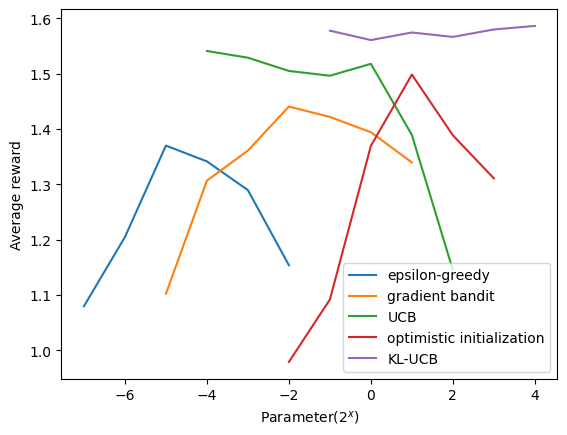

In [5]:
runs = 500
time = 1000

labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization',
         'KL-UCB']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1),
                     lambda cval: Bandit(epsilon=0, KL_param=cval, KLUCB=True, sample_averages=True)]
parameters = [np.arange(-7, -1, dtype=float),
                  np.arange(-5, 2, dtype=float),
                  np.arange(-4, 3, dtype=float),
                  np.arange(-2, 4, dtype=float),
                  np.arange(-1, 5, dtype=float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l

plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()
plt.show